# Accessing Optical Absorption and Attenuation (OPTAA) Data from the OOI M2M Interface

The current system does not properly display the OPTAA data in way that can be used to assess data quality. We need to download the data and rework the data sets in order to plot the data spectrally as well as to derive additional data products that can be used in cross-comparisons with other sensors.

In [16]:
import datetime
import numpy as np
import os

%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn-white')

from ooi_data_explorations.common import m2m_request, m2m_collect

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setup needed parameters for the request
site = 'CE01ISSM'           # OOI Net site designator
node = 'RID16'              # OOI Net node designator
sensor = '01-OPTAAD000'     # OOI Net sensor designator
stream = 'optaa_dj_dcl_instrument'  # OOI Net stream name
method = 'telemetered'      # OOI Net data delivery method

# Set the start date to July 15, 2020. Leaving the stop date empty will request through the end of the record.
start = '2020-07-15T00:00:00.000Z'    # explicit date/time format required for M2M requests

# request the data
r = m2m_request(site, node, sensor, method, stream, start)
optaa = m2m_collect(r, '.*OPTAA.*\\.nc$')

Requesting:
	refdes: CE01ISSM-RID16-01-OPTAAD000
	method: telemetered
	stream: optaa_dj_dcl_instrument
	from 2020-07-15T00:00:00.000Z to None
Waiting for OOINet to process and prepare data request, this may take up to 20 minutes.
Waiting: 100%|██████████| 12/12 [18:13<00:00, 91.12s/it] 


In [3]:
optaa

<xarray.Dataset>
Dimensions:                  (time: 654763, wavelength: 78)
Coordinates:
  * wavelength               (wavelength) int32 0 1 2 3 4 5 ... 73 74 75 76 77
  * time                     (time) datetime64[ns] 2020-12-14T00:27:58 ... 20...
Data variables:
    external_temp_raw        (time) float32 39346.0 39348.0 ... 40830.0 40828.0
    elapsed_run_time         (time) float64 1.018e+04 1.043e+04 ... 1.085e+05
    internal_timestamp       (time) datetime64[ns] 2020-12-14T00:27:58 ... 20...
    internal_temp_raw        (time) float32 50519.0 50510.0 ... 51315.0 51321.0
    c_reference_dark_counts  (time) float32 475.0 475.0 475.0 ... 471.0 472.0
    num_wavelengths          (time) float32 78.0 78.0 78.0 ... 78.0 78.0 78.0
    deployment               (time) int32 13 13 13 13 13 13 ... 13 13 13 13 13
    c_signal_dark_counts     (time) float32 715.0 715.0 716.0 ... 712.0 713.0
    pressure_counts          (time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    a_signal_dark_counts     (time) float32 649.0 648.0 649.0 ... 655.0 655.0
    a_reference_dark_counts  (time) float32 466.0 465.0 466.0 ... 464.0 464.0
    wavelength_a             (time, wavelength) float64 400.3 403.9 ... 735.1
    wavelength_c             (time, wavelength) float64 400.7 404.4 ... 736.2
    practical_salinity       (time) float64 31.8 31.8 31.8 ... 33.92 33.92 33.92
    temp                     (time) float64 10.22 10.22 10.22 ... 7.802 7.802
    c_signal_counts          (time, wavelength) float32 82.0 88.0 ... 5425.0
    a_signal_counts          (time, wavelength) float32 193.0 239.0 ... 6953.0
    a_reference_counts       (time, wavelength) float32 536.0 630.0 ... 7755.0
    c_reference_counts       (time, wavelength) float32 743.0 852.0 ... 6998.0
    beam_attenuation         (time, wavelength) float64 8.79 9.094 ... 0.3335
    optical_absorption       (time, wavelength) float64 2.116 2.025 ... -0.01971
Attributes:
    node:                               RID16
    comment:                            Data collected from the OOI M2M API a...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  telemetered
    stream:                             optaa_dj_dcl_instrument
    featureType:                        timeSeries
    creator_email:                      
    publisher_name:                     Ocean Observatories Initiative
    date_modified:                      2020-12-21T14:59:46.885270
    keywords:                           
    cdm_data_type:                      Station
    references:                         More information can be found at http...
    Metadata_Conventions:               Unidata Dataset Discovery v1.0
    date_created:                       2020-12-21T14:59:46.885263
    id:                                 CE01ISSM-RID16-01-OPTAAD000-telemeter...
    requestUUID:                        0aec41a4-8b23-42c8-adc7-3ad965f9e9db
    contributor_role:                   
    summary:                            Dataset Generated by Stream Engine fr...
    keywords_vocabulary:                
    institution:                        Ocean Observatories Initiative
    naming_authority:                   org.oceanobservatories
    infoUrl:                            http://oceanobservatories.org/
    license:                            
    contributor_name:                   
    uuid:                               0aec41a4-8b23-42c8-adc7-3ad965f9e9db
    creator_name:                       Ocean Observatories Initiative
    title:                              Data produced by Stream Engine versio...
    sensor:                             01-OPTAAD000
    standard_name_vocabulary:           NetCDF Climate and Forecast (CF) Meta...
    acknowledgement:                    National Science Foundation
    Conventions:                        CF-1.6
    project:                            Ocean Observatories Initiative
    source:     

In [4]:
# Delete the first 60 seconds of the data record per recommendation from the vendor
optaa.elapsed_run_time.values = optaa.elapsed_run_time.where(optaa.elapsed_run_time / 1000 > 60)
optaa = optaa.dropna(dim='time', subset=['elapsed_run_time'])
optaa = optaa.sortby('time')

# median average each burst
burst = optaa.resample(time='15Min', keep_attrs=True, base=55, loffset='5Min').median()
burst = burst.dropna(dim='time')
burst

<xarray.Dataset>
Dimensions:                  (time: 1665, wavelength: 78)
Coordinates:
  * time                     (time) datetime64[ns] 2020-07-15T00:30:00 ... 20...
  * wavelength               (wavelength) int32 0 1 2 3 4 5 ... 73 74 75 76 77
Data variables:
    external_temp_raw        (time) float32 40624.0 40562.0 ... 39184.0 39225.0
    elapsed_run_time         (time) float64 8.431e+04 8.331e+04 ... 8.379e+04
    internal_temp_raw        (time) float32 51211.0 51174.0 ... 50428.0 50450.0
    c_reference_dark_counts  (time) float32 473.0 473.0 473.0 ... 472.0 472.0
    num_wavelengths          (time) float32 78.0 78.0 78.0 ... 78.0 78.0 78.0
    deployment               (time) float64 13.0 13.0 13.0 ... 13.0 13.0 13.0
    c_signal_dark_counts     (time) float32 713.0 713.0 714.0 ... 713.0 713.0
    pressure_counts          (time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    a_signal_dark_counts     (time) float32 651.0 650.0 652.0 ... 656.0 656.0
    a_reference_dark_counts  (time) float32 463.0 461.0 462.0 ... 464.0 464.0
    wavelength_a             (time, wavelength) float64 400.3 403.9 ... 735.1
    wavelength_c             (time, wavelength) float64 400.7 404.4 ... 736.2
    practical_salinity       (time) float64 33.86 33.84 33.84 ... 31.01 30.56
    temp                     (time) float64 8.144 8.271 8.403 ... 10.48 10.41
    c_signal_counts          (time, wavelength) float32 565.5 657.0 ... 1031.0
    a_signal_counts          (time, wavelength) float32 452.0 563.0 ... 4327.5
    a_reference_counts       (time, wavelength) float32 555.0 655.0 ... 7636.0
    c_reference_counts       (time, wavelength) float32 751.0 864.0 ... 6878.0
    beam_attenuation         (time, wavelength) float64 1.104 1.099 ... 6.874
    optical_absorption       (time, wavelength) float64 0.3095 0.304 ... -0.1011

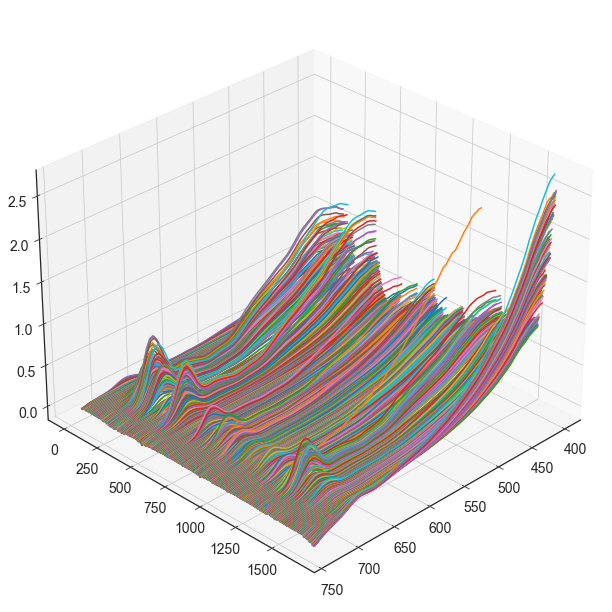

In [5]:
%matplotlib inline

# Plot the optical absorption data
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(17,11))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 45)

for i in range(burst.dims['time']):
    data = burst.isel(time=i)
    ax.plot3D(data.wavelength_a, np.tile(i, data.dims['wavelength']), data.optical_absorption)
    
plt.show()

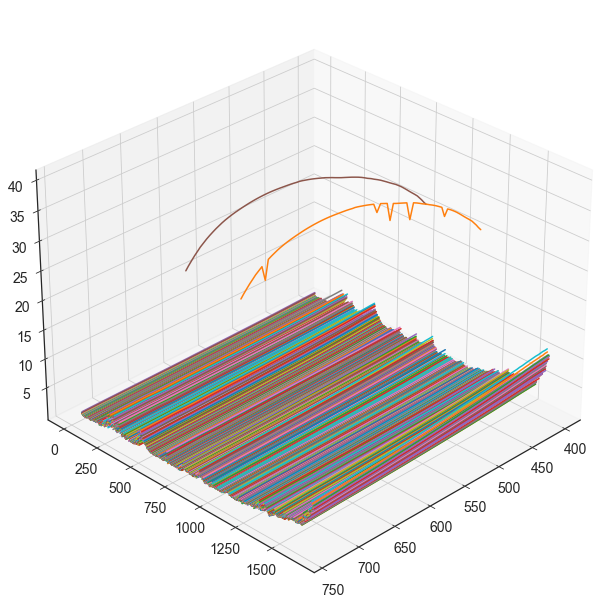

In [6]:
# Plot the optical absorption data
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(17,11))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 45)

for i in range(burst.dims['time']):
    data = burst.isel(time=i)
    ax.plot3D(data.wavelength_c, np.tile(i, data.dims['wavelength']), data.beam_attenuation)
    
plt.show()

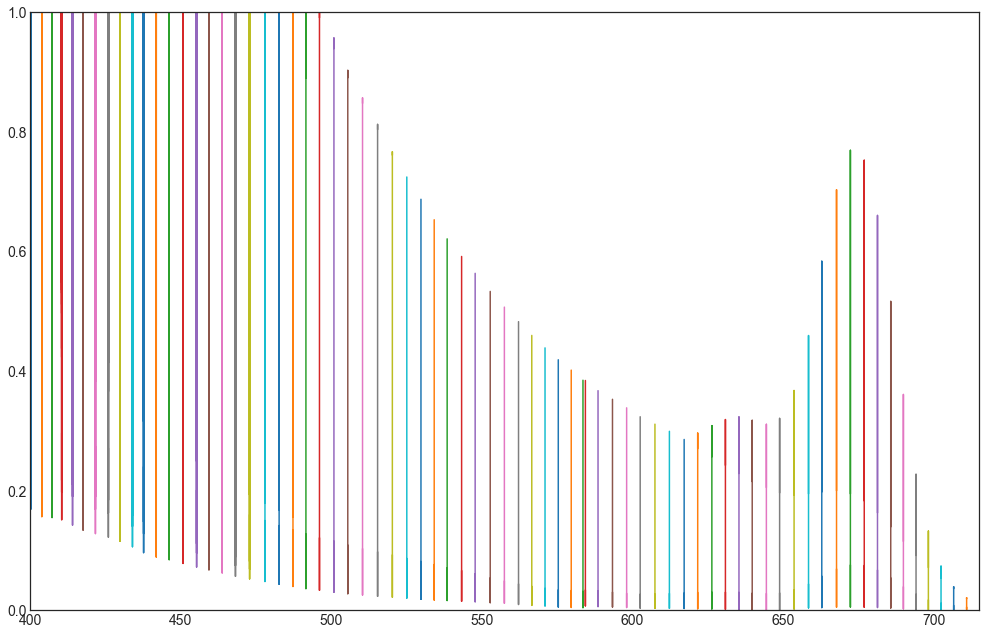

In [8]:
%matplotlib inline

plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(17,11))
plt.plot(burst.wavelength_a, burst.optical_absorption)
plt.xlim(400, 715)
plt.ylim(0, 1)
plt.show()

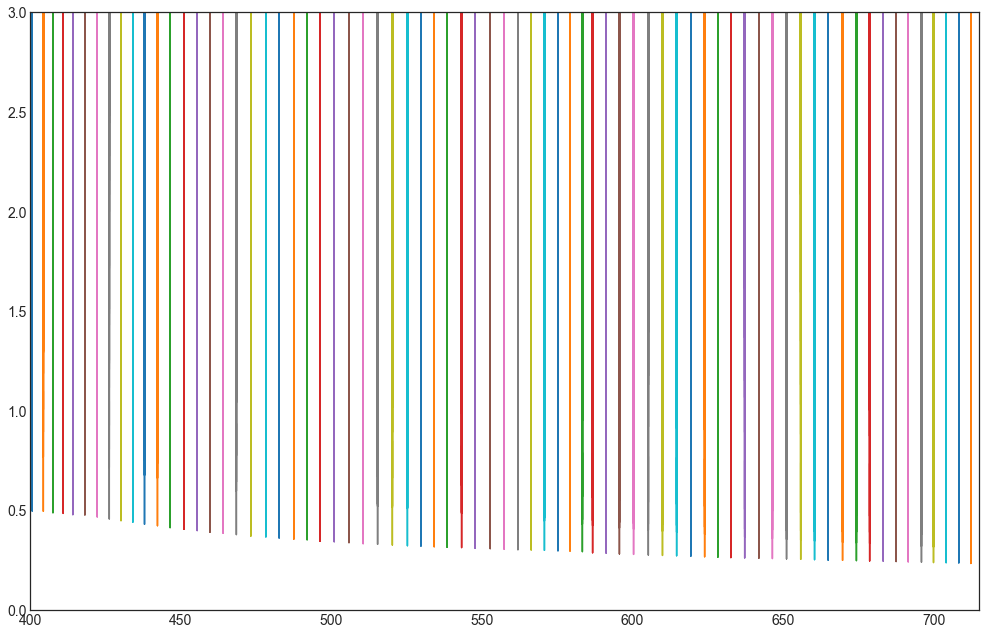

In [9]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(17,11))
plt.plot(burst.wavelength_c, burst.beam_attenuation)
plt.xlim(400, 715)
plt.ylim(0, 3)
plt.show()

In [20]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(17,11))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for i in range(1400, 1500):
    data = burst.isel(time=i)
    ax1.plot(data.wavelength_a, data.optical_absorption)
    ax2.plot(data.wavelength_c, data.beam_attenuation)

plt.show()

In [19]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(17,11))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(burst.time, burst.optical_absorption[:,0])
ax2.plot(burst.time, burst.beam_attenuation[:,0])

plt.ion()
plt.show()